In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
DIRin1 = "/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/"
DIRtrain = os.path.join(DIRin1,"train_images")

In [76]:
train_df = pd.read_csv(os.path.join(DIRin1, "train.csv"))
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [77]:
# Transform class to column
try:
    train_df['fname'], train_df['cls'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
except:
    train_df['fname'], train_df['cls'] = train_df['ImageId'], train_df['ClassId']
train_df['cls'] = train_df['cls'].astype(int)
train_df = train_df.pivot(index='fname',columns='cls',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)

In [78]:
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

### 데이터 전처리 v0

1. 결함 영역 이미지 crop
2. 결함 이미지를 256 by 256 중앙에 위치
3. gray color로 상하좌우 패딩

In [41]:
def show_mask_image_v0(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):

            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                x, y, w, h = cv2.boundingRect(contours[i])
                if w >= 256:
                    w = 256
                if w >=2 and h >=2:
                    # print(ch+1,x,y,w,h)
                    defect_crop = img[y:y + h, x:x + w]

                    # Add padding to make it 256x256
                    pad_x = max(0, (256 - w) // 2)
                    pad_y = max(0, (256 - h) // 2)
                    defect_crop_padded = cv2.copyMakeBorder(defect_crop, pad_y, 256 - h - pad_y, pad_x, 256 - w - pad_x,
                                                            cv2.BORDER_CONSTANT, value=(128, 128, 128))  # Use gray color for padding


                    fig, ax = plt.subplots(figsize=(3,3))

                    ax.set_title(f"defect_num: {ch+1}, image:"+name)
                    ax.imshow(defect_crop_padded)
                    ax.axis('off')
                    plt.show()

                    # Save the defect_crop_padded image
                    dir_name = "/content/drive/MyDrive/졸업과제/image/"+str(ch+1)+"/"+name.split(".")[0]+f"_crop_{i + 1}.png"
                    cv2.imwrite(dir_name, defect_crop_padded)


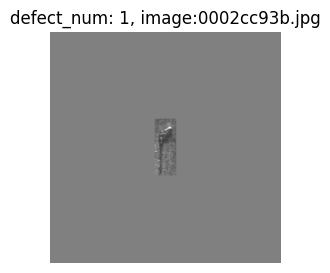

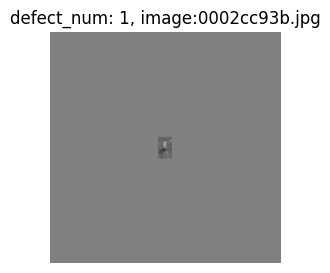

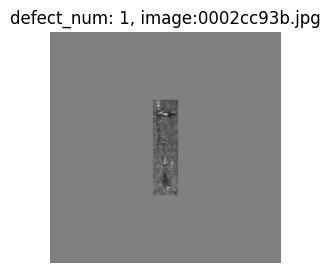

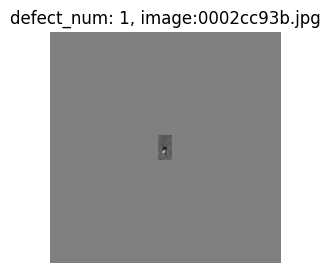

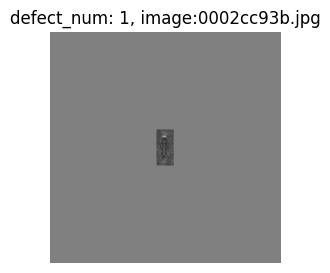

In [53]:
show_mask_image_v0(0)

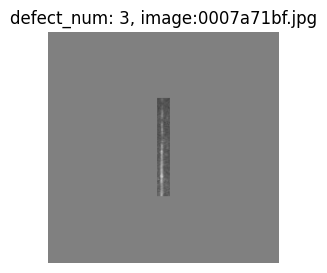

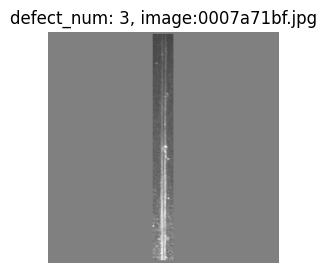

In [56]:
show_mask_image_v0(1)

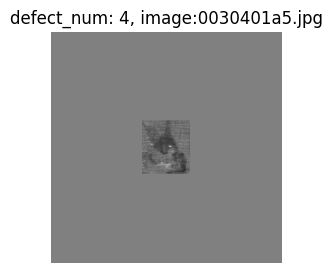

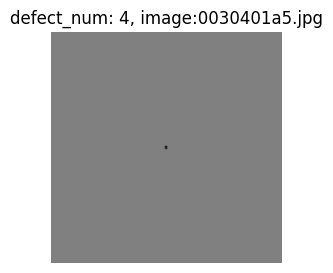

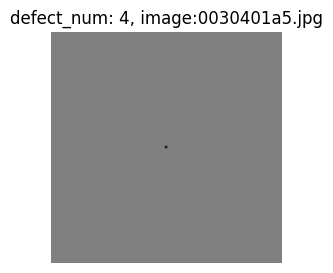

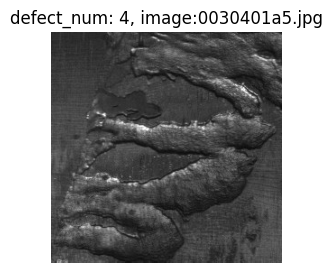

In [55]:
show_mask_image_v0(8)

### 데이터 전처리 v1
1. 결함 영역 이미지 crop
2. 결함 이미지 확대(비율 유지)
3. 256 by 256 중앙에 위치
4. gray color로 패딩

In [81]:
def show_mask_image_v1(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):

            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                x, y, w, h = cv2.boundingRect(contours[i])
                if w >= 256:
                    w = 256
                if w >=2 and h >=2:
                    # print(ch+1,x,y,w,h)
                    defect_crop = img[y:y + h, x:x + w]

                    if w < 256 and h < 256:
                        if w > h :
                          # w : h = 256 : x -> x = 256 * h / w
                          new_w = 256
                          new_h = int(256*h/w)
                        else:
                          # w : h = x : 256 -> x = 256 * w / h
                          new_h = 256
                          new_w = int(256*w/h)

                        defect_crop_resized = cv2.resize(defect_crop, (new_w, new_h))

                        # Add padding to make it 256x256
                        pad_x = max(0, (256 - new_w) // 2)
                        pad_y = max(0, (256 - new_h) // 2)
                        defect_crop_padded = cv2.copyMakeBorder(defect_crop_resized, pad_y, 256 - new_h - pad_y, pad_x,
                                                                256 - new_w - pad_x, cv2.BORDER_CONSTANT, value=(128, 128, 128))
                    else:
                        # Add padding to make it 256x256
                        pad_x = max(0, (256 - w) // 2)
                        pad_y = max(0, (256 - h) // 2)
                        defect_crop_padded = cv2.copyMakeBorder(defect_crop, pad_y, 256 - h - pad_y, pad_x, 256 - w - pad_x,
                                                                cv2.BORDER_CONSTANT, value=(128, 128, 128))

                    fig, ax = plt.subplots(figsize=(3,3))

                    ax.set_title(f"defect_num: {ch+1}, image:"+name)
                    ax.imshow(defect_crop_padded)
                    ax.axis('off')
                    plt.show()

                    # Save the defect_crop_padded image
                    dir_name = "/content/drive/MyDrive/졸업과제/image/"+str(ch+1)+"/"+name.split(".")[0]+f"_crop_{i + 1}.png"
                    cv2.imwrite(dir_name, defect_crop_padded)



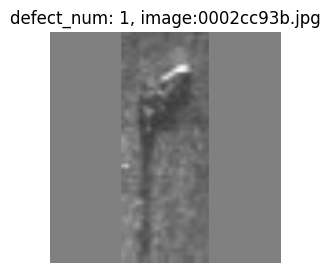

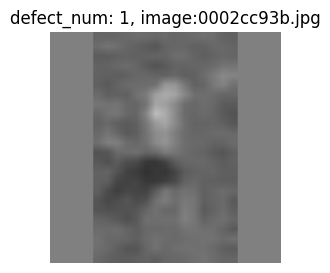

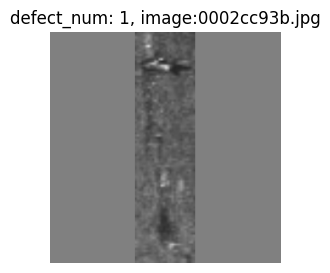

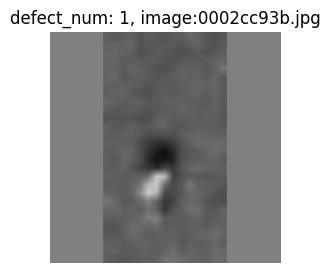

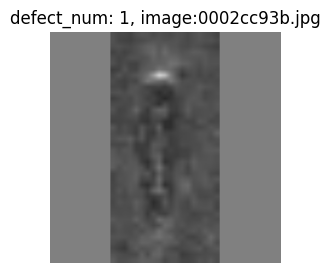

In [82]:
show_mask_image_v1(0)

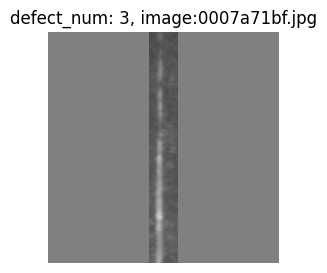

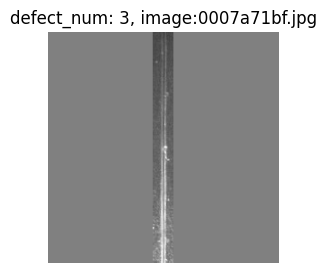

In [83]:
show_mask_image_v1(1)

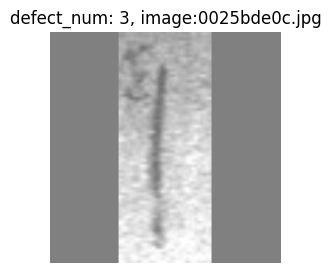

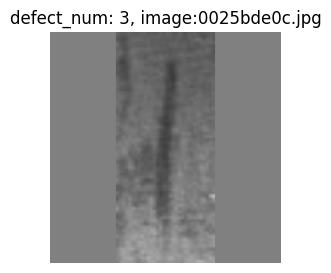

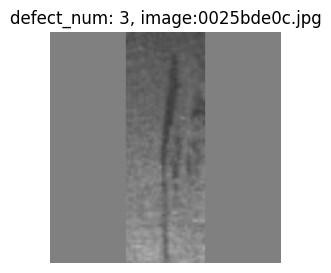

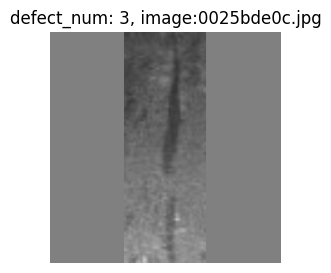

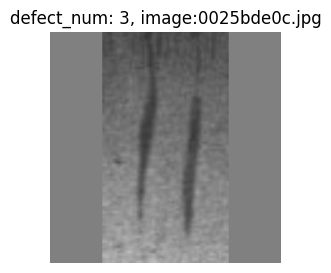

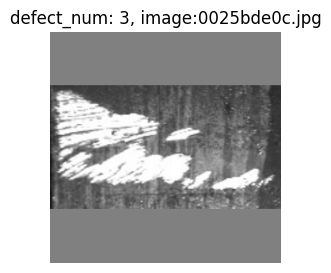

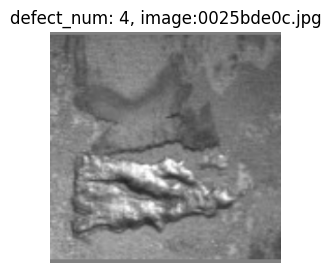

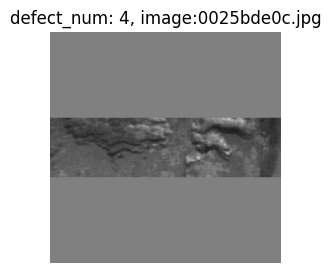

In [91]:
show_mask_image_v1(5)